## Establish sampling baseline for active learning techniques with embedding model 2

### Let's use embedding model 2, trained on only 500 datapoints

In [25]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import tensorflow as tf

data_dir = "../../data/"
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

# get categorical data
X1 = train_vals_df[["geo_level_1_id", "geo_level_2_id", "position", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "plan_configuration", "legal_ownership_status"]].to_numpy()

enc = OrdinalEncoder()
enc.fit(X1)
X1 = enc.transform(X1)

## get numerical data
df = train_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)


# get labels

y = train_labels_df["damage_grade"].to_numpy()
y = np.eye(3)[y-1]

X = np.concatenate((X1,X2), axis = 1)
# X = np.asarray(X).astype('float32')

In [26]:
rng = np.random.RandomState(7)
perm = rng.permutation(range(len(X)))
X_rand = X[perm]
y_rand = y[perm]

seedSize = 500
X_train = X[:seedSize ]
y_train = y[:seedSize ]

# unlabeled dataset
X_u = X[seedSize :int(.7*len(X))]
y_u = y[seedSize :int(.7*len(X))]

X_val = X[int(.7*len(X)):int(.85*len(X))]
y_val = y[int(.7*len(X)):int(.85*len(X))]
X_test = X[int(.85*len(X)):]
y_test = y[int(.85*len(X)):]

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Embedding

checkpoint_filepath = '/tmp/saved_models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

## Creating the layers
batch_size = 2048
input = Input(shape=(13,)) 
embedding0 = Embedding(31, 2)(input[:,0]) # geo id 1
embedding1 = Embedding(1428, 2)(input[:,1]) # geo id 2
embedding2 = Embedding(4, 2)(input[:,2]) # position
embedding3 = Embedding(5, 2)(input[:,3]) # foundation type
embedding4 = Embedding(3, 2)(input[:,4]) # roof type
embedding5 = Embedding(5, 2)(input[:,5]) # ground floor type
embedding6 = Embedding(4, 2)(input[:,6]) # other floor type
embedding7 = Embedding(10, 3)(input[:,7]) # plan configuration
embedding8 = Embedding(4, 2)(input[:,8]) # legal ownership status
Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6, embedding7, embedding8, input[:,9:]], 1))
# Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4, input[:,5:]], 1))
Layer_2 = Dense(15, activation="relu")(Layer_1)
Layer_3 = Dense(10, activation="relu")(Layer_2)
output_layer= Dense(3, activation="softmax")(Layer_3)

model = tf.keras.Model(inputs=input, outputs=output_layer, name="emb_model")
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['CategoricalAccuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
1/1 [==============================] - 1s 800ms/step - loss: 1.1018 - categorical_accuracy: 0.2080 - val_loss: 1.1010 - val_categorical_accuracy: 0.2099
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 1.1016 - categorical_accuracy: 0.2180 - val_loss: 1.1008 - val_categorical_accuracy: 0.2209
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 1.1014 - categorical_accuracy: 0.2240 - val_loss: 1.1007 - val_categorical_accuracy: 0.2342
Epoch 4/100
1/1 [==============================] - 0s 52ms/step - loss: 1.1012 - categorical_accuracy: 0.2400 - val_loss: 1.1005 - val_categorical_accuracy: 0.2474
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 1.1010 - categorical_accuracy: 0.2460 - val_loss: 1.1003 - val_categorical_accuracy: 0.2616
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 1.1008 - categorical_accuracy: 0.2640 - val_loss: 1.1001 - val_categorical_accuracy: 0.2754
Epoch 7/100
1/1

In [28]:
from scipy.stats import entropy
def update_training_data(model, X_train, y_train, X_u, y_u, new_data_size = 1000, method = "margin_sampling"):
    # Params:
    # model is currently trained model
    # X_train and y_train are current training data
    # X_u and y_u are current unlabeled data to select new training data from

    # returns:
    # new X_train, y_train, X_u, y_u 
    if method == "margin_sampling":
        preds = model.predict(X_u)
        margins = []
        for pred in preds:
            sorted = pred[np.argsort(pred)]
            margins.append(sorted[-1] - sorted[-2]) 

        margins = np.array(margins)

        selected_idxs = np.argpartition(margins, new_data_size)[:new_data_size]
        not_selected_idxs = np.array(list(set(range(len(X_u))) - set(selected_idxs)))

        X_train = np.concatenate((X_train, X_u[selected_idxs]), axis = 0)
        y_train = np.concatenate((y_train, y_u[selected_idxs]), axis = 0)
        X_u = X_u[not_selected_idxs]
        y_u = y_u[not_selected_idxs]
    

        return X_train, y_train, X_u, y_u

    elif method == "random_sampling":
        perm = np.random.permutation(len(X_u))
        X_u = X_u[perm]
        y_u = y_u[perm]
        selected_idxs = np.array(list(range(0,new_data_size)))
        not_selected_idxs = np.array(list(range(new_data_size,len(X_u))))

        X_train = np.concatenate((X_train, X_u[selected_idxs]), axis = 0)
        y_train = np.concatenate((y_train, y_u[selected_idxs]), axis = 0)
        X_u = X_u[not_selected_idxs]
        y_u = y_u[not_selected_idxs]
    

        return X_train, y_train, X_u, y_u



    elif method == "entropy_sampling":
        preds = model.predict(X_u)
        entrops = []
        for idx, pred in enumerate(preds):
            entrop = stats.entropy(pred, y_u[idx])
            entrops.append(entrop)

        entrops = np.array(entrops)

        selected_idxs = np.argpartition(entrops, -new_data_size)[-new_data_size:]
        not_selected_idxs = np.array(list(set(range(len(X_u))) - set(selected_idxs)))

        X_train = np.concatenate((X_train, X_u[selected_idxs]), axis = 0)
        y_train = np.concatenate((y_train, y_u[selected_idxs]), axis = 0)
        X_u = X_u[not_selected_idxs]
        y_u = y_u[not_selected_idxs]
    

        return X_train, y_train, X_u, y_u

    else:
        raise NotImplementedError("The method {} has not been implemented".format(method))

## Run random sampling


In [29]:
import time
val_accs = []
while history.history["val_categorical_accuracy"][-1] < .675:
    X_train, y_train, X_u, y_u = update_training_data(model, X_train, y_train, X_u, y_u, new_data_size = 500, method = "random_sampling")
    model.reset_states()
    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
    print("Trained on {} unique samples total".format(len(X_train)))
    val_acc = history.history["val_categorical_accuracy"][-1]
    print("New val accuracy is {}".format(val_acc))
    val_accs.append(val_acc)
    time.sleep(1)

Epoch 1/100
1/1 [==============================] - 0s 84ms/step - loss: 1.0792 - categorical_accuracy: 0.5680 - val_loss: 1.0787 - val_categorical_accuracy: 0.5685
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 1.0789 - categorical_accuracy: 0.5680 - val_loss: 1.0784 - val_categorical_accuracy: 0.5685
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 1.0786 - categorical_accuracy: 0.5680 - val_loss: 1.0782 - val_categorical_accuracy: 0.5686
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 1.0784 - categorical_accuracy: 0.5680 - val_loss: 1.0779 - val_categorical_accuracy: 0.5688
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0781 - categorical_accuracy: 0.5680 - val_loss: 1.0776 - val_categorical_accuracy: 0.5688
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0778 - categorical_accuracy: 0.5680 - val_loss: 1.0774 - val_categorical_accuracy: 0.5690
Epoch 7/100
1/1 

## Show the model's performance increase during margin sampling

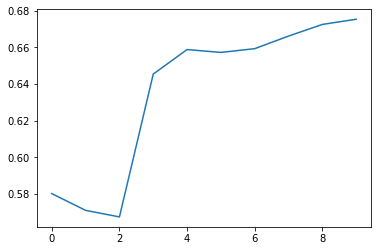

In [30]:
import matplotlib.pyplot as plt

plt.plot(val_accs)